# Naive Bayes


En este notebook se van a estar trabajando los modelos basados en Naive Bayes. Estos modelos son relativamente sencillos. ....

## Configuraciones iniciales

Cargamos las bibliotecas correspondientes a este modelo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import CategoricalNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

from preprocessing import prepararSetDeDatos
from preprocessing import categoricalNBPreprocessing

## Carga y preparacion del set de datos

Cargamos ambos set de datos, y se los pasamos a la funcion que realiza el armado hecho para el TP1.

In [2]:
y = pd.read_csv('Datasets/tp-2020-2c-train-cols1.csv')

In [3]:
X = pd.read_csv('Datasets/tp-2020-2c-train-cols2.csv')

In [4]:
X,y = prepararSetDeDatos(X,y)

## CategoricalNB

In [5]:
X_categoricalNB = categoricalNBPreprocessing(X)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_categoricalNB, y, test_size=0.25, random_state=0)

In [7]:
categoricalNB = CategoricalNB()

In [8]:
categoricalNB.fit(X_train, y_train)

C:\Users\Bruno\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


CategoricalNB()

Realizamos ahora las predicciones correspondientes con la parte de entrenamiento y la de pruebas, una vez hecho eso, mostramos las metricas obtenidas en cada uno.

In [9]:
y_pred = categoricalNB.predict(X_train)
print(classification_report(y_train, y_pred, target_names=['No vuelve','Vuelve']))

              precision    recall  f1-score   support

   No vuelve       0.84      0.81      0.82       373
      Vuelve       0.70      0.74      0.72       227

    accuracy                           0.78       600
   macro avg       0.77      0.78      0.77       600
weighted avg       0.79      0.78      0.78       600



EXPLICACION?????

In [10]:
y_pred = categoricalNB.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['No vuelve','Vuelve']))

              precision    recall  f1-score   support

   No vuelve       0.85      0.80      0.83       121
      Vuelve       0.72      0.79      0.75        80

    accuracy                           0.80       201
   macro avg       0.79      0.79      0.79       201
weighted avg       0.80      0.80      0.80       201



EXPLICACION???????

In [11]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

Text(45.72222222222221, 0.5, 'Real')

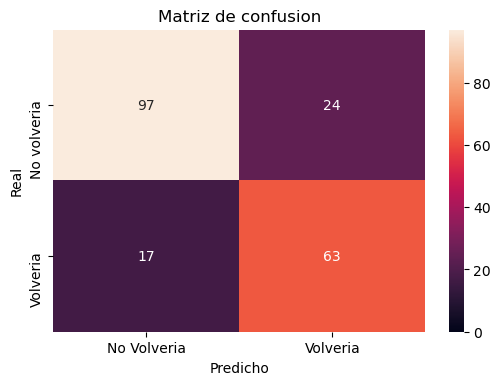

In [12]:
fig, ax = plt.subplots(dpi=100)
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, vmin = 0, yticklabels=["No volveria","Volveria"], xticklabels=[ "No Volveria","Volveria"], ax=ax)
ax.set_title("Matriz de confusion")
ax.set_xlabel("Predicho")
ax.set_ylabel("Real")

EXPLICACION???????

Graficamos ahora la curva ROC para ambos casos.

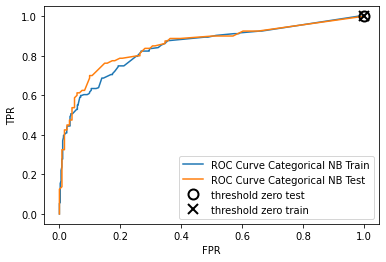

In [13]:
fpr_cnb_test,tpr_cnb_test,thresholds_cnb_test = roc_curve(y_test,categoricalNB.predict_proba(X_test)[:,1])
fpr_cnb_train,tpr_cnb_train,thresholds_cnb_train = roc_curve(y_train,categoricalNB.predict_proba(X_train)[:,1])

zero_test = np.argmin(np.abs(thresholds_cnb_test))
zero_train = np.argmin(np.abs(thresholds_cnb_train))

plt.plot(fpr_cnb_train,tpr_cnb_train,label="ROC Curve Categorical NB Train")
plt.plot(fpr_cnb_test,tpr_cnb_test,label="ROC Curve Categorical NB Test")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(fpr_cnb_test[zero_test],tpr_cnb_test[zero_test],'o',markersize=10,label="threshold zero test",fillstyle="none",c="k",mew=2)
plt.plot(fpr_cnb_train[zero_train],tpr_cnb_train[zero_train],'x',markersize=10,label="threshold zero train",fillstyle="none",c="k",mew=2)

plt.legend(loc=4)

EXPLICACION??????

In [14]:
auc_cnb = roc_auc_score(y_test,categoricalNB.predict_proba(X_test)[:, 1])
print("AUC para categorical NB: {:.3f}".format(auc_cnb))

AUC para categorical NB: 0.857


PREDICIR EL OTRO ARCHIVO Y GUARDAR LOS VALROES

In [51]:
mejor_valor = None
mejor_alpha = None
z=np.array(y)
print(z.shape)
print(X_categoricalNB.shape)
for valor_alpha in [0.1,0.3,0.5,0.7,1]:
    kf = StratifiedKFold(n_splits=5)
    metricas = []
    for fold_idx, (train_index, test_index) in enumerate(kf.split(X_categoricalNB, z)):
        categoricalNB = CategoricalNB(alpha=valor_alpha)
        categoricalNB.fit(X_categoricalNB[train_index], z[train_index])
        print("Division")
        print(train_index.shape)
        print(test_index.shape)
        print("train")
        print(train_index)
        print("test")
        print(test_index)
        print("metricas")
        a = categoricalNB.predict(X_categoricalNB[test_index])
        print(a)
        b = roc_auc_score(z[test_index],a)
        print(b)
        metricas.append(b)
        
    if not mejor_valor or np.mean(metricas) < mejor_valor:
        mejor_valor = np.mean(metricas)
        mejor_alpha = valor_alpha

(801, 1)
(801, 7)
Division
(640,)
(161,)
train
[160 161 162 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232
 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250
 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268
 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286
 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304
 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322
 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340
 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358
 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376
 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394
 395

C:\Users\Bruno\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Bruno\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Bruno\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Bruno\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

IndexError: index 6 is out of bounds for axis 1 with size 6

## MultinomialNB

## GaussianNB